## Importing the required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.0 MB/s eta 0:00:00


In [14]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.backends.backend_svg
import tensorflow as tf
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import resampy

In [4]:
from keras import regularizers

In [5]:
import os

In [6]:
mylist= os.listdir('/content/drive/MyDrive/rawdata_new/')

In [7]:
type(mylist)

list

In [8]:
print(mylist[100])

03-01-03-02-02-01-15.wav


In [9]:
len(mylist)

2264

In [10]:
print(mylist[500][6:8])

05


## Plotting the audio file's waveform and its spectrogram

In [ ]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/rawdata_new/03-02-06-02-02-02-23.wav')

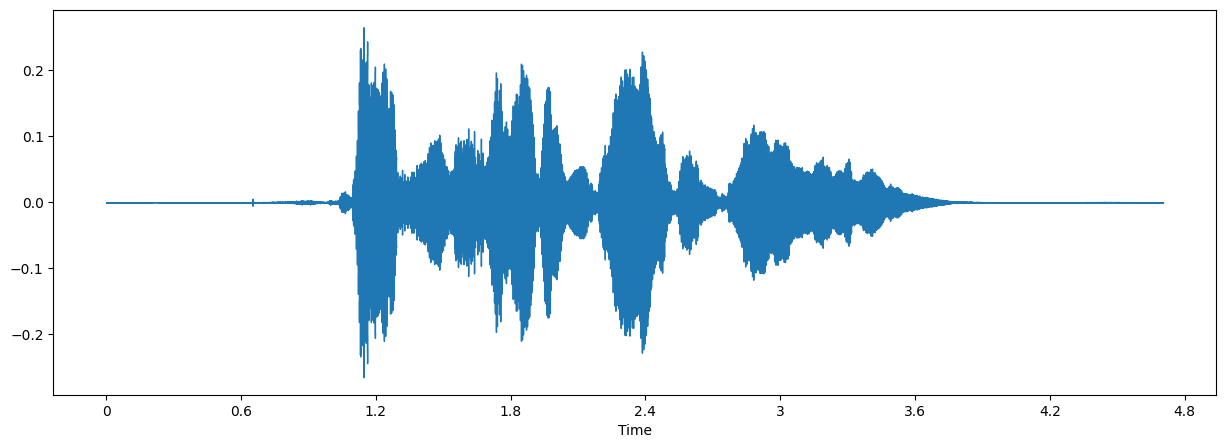

In [ ]:
%matplotlib inline
import os
import pandas as pd
import librosa
import glob
import scipy.io.wavfile
import numpy as np
import sys

fig = plt.figure(figsize=(15, 5));
librosa.display.waveshow(data, sr=sampling_rate);
fig.savefig('/content/drive/MyDrive/waveshow_plots/2')

<ipython-input-14-c7e9be997fd8>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('/content/drive/MyDrive/rawdata_new/03-02-06-02-02-02-24.wav')
<ipython-input-14-c7e9be997fd8>:20: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


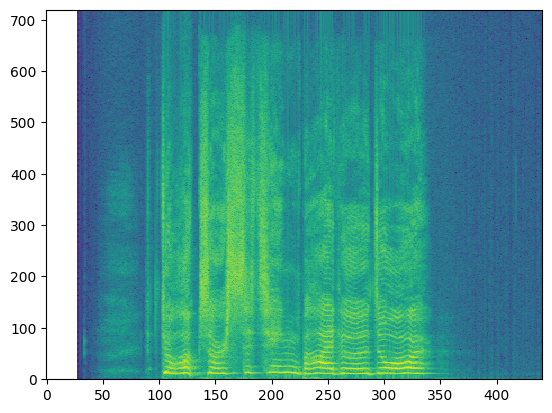

In [ ]:
sr,x = scipy.io.wavfile.read('/content/drive/MyDrive/rawdata_new/03-02-06-02-02-02-24.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto');

plt.show();

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='01' and int(item[18:-4])%2==0:
        feeling_list.append('female_neutral')
    elif item[6:-16]=='01' and int(item[18:-4])%2==1:
        feeling_list.append('male_neutral')
    elif item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[6:-16]=='07' and int(item[18:-4])%2==0:
        feeling_list.append('female_disgusted')
    elif item[6:-16]=='07' and int(item[18:-4])%2==1:
        feeling_list.append('male_disgusted')
    elif item[6:-16]=='08' and int(item[18:-4])%2==0:
        feeling_list.append('female_surprised')
    elif item[6:-16]=='08' and int(item[18:-4])%2==1:
        feeling_list.append('male_surprised')

    #elif item[:1]=='a':
    #    feeling_list.append('male_angry')
    #elif item[:1]=='f':
    #    feeling_list.append('male_fearful')
    #elif item[:1]=='h':
    #   feeling_list.append('male_happy')
    #elif item[:1]=='n':
    # feeling_list.append('neutral')
    #elif item[:2]=='sa':
    #    feeling_list.append('male_sad')

In [15]:
labels = pd.DataFrame(feeling_list, columns=['label'])

In [16]:
labels

,label
0,female_happy
1,female_happy
2,female_happy
3,female_sad
4,female_sad
...,...
2259,male_happy
2260,male_calm
2261,male_calm
2262,male_happy


In [17]:
len(labels)

2264

## Getting the features of audio files using librosa

In [ ]:
X, sample_rate = librosa.load(f'/content/drive/MyDrive/rawdata_new/03-02-06-02-02-02-24.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)

In [ ]:
for i,j in enumerate(mylist):
  data, sampling_rate = librosa.load(f'/content/drive/MyDrive/rawdata_new/{j}')
  plt.figure(figsize=(15, 5));
  librosa.display.waveshow(data, sr=sampling_rate);
  fig.savefig(f'/content/drive/MyDrive/waveshow_plots/{i}')

<ipython-input-21-7e84141e43ed>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5));


In [18]:
import resampy
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    #if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08':
      # and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
      X, sample_rate = librosa.load(f'/content/drive/MyDrive/rawdata_new/{y}', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
      sample_rate = np.array(sample_rate)
      mfccs = np.mean(librosa.feature.mfcc(y=X,
                                            sr=sample_rate,
                                            n_mfcc=13),
                        axis=0)
      feature = mfccs
      #[float(i) for i in feature]
      #feature1=feature[:135]
      df.loc[bookmark] = [feature]
      bookmark=bookmark+1

KeyboardInterrupt: ignored

In [ ]:
len(df_tolist)

2264

In [ ]:
df_tolist = pd.DataFrame(df['feature'].values.tolist())

In [ ]:
from google.colab import files

df_tolist.to_csv('df_tolist_final_csv.csv')
files.download('df_tolist_final_csv.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_final = pd.read_csv('/content/drive/MyDrive/df_tolist_csv.csv', index_col=0)

In [ ]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [ ]:
len(df_tolist), len(labels)

(2264, 2264)

In [ ]:
df_final

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-65.646545,-65.646545,-65.646545,-65.646545,-65.646545,-65.646545,-65.717870,-65.717094,-65.770775,-65.646545,...,-55.518390,-57.588770,-57.379380,-57.319004,-57.521870,-57.882183,-58.107506,-58.743729,-61.777081,-62.674698
1,-50.220170,-50.220170,-50.398727,-50.745308,-51.076940,-50.710587,-49.991745,-48.946102,-47.251717,-45.801384,...,-49.845440,-49.453106,-49.775980,-50.220170,-50.220169,-50.220169,-50.220169,-50.220169,-50.220169,-50.220169
2,-57.643570,-57.643570,-57.643898,-57.643570,-57.643570,-57.643570,-57.643570,-57.643570,-57.643570,-57.643570,...,-46.744530,-46.719700,-45.318768,-42.928505,-44.548965,-45.091454,-43.469318,-43.026325,-30.374559,-22.562649
3,-50.720930,-47.694363,-47.407060,-48.722590,-50.155910,-49.914307,-50.302773,-49.821010,-48.415573,-47.448430,...,-40.761090,-41.046402,-40.217440,-41.339436,-40.097435,-41.549973,-40.854042,-41.652805,-36.015892,-27.500872
4,-54.798035,-54.798035,-54.798035,-54.798035,-54.798035,-54.798035,-54.798035,-54.798035,-54.798035,-54.798035,...,-27.953352,-31.704247,-33.133030,-32.071484,-29.349466,-28.547337,-30.097216,-29.029085,-21.980854,-15.559300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,-51.723280,-49.404106,-49.573555,-49.531060,-51.778940,-49.248875,-49.241272,-49.972477,-51.259895,-50.161514,...,-49.727190,-50.108803,-50.828667,-51.525590,-50.563255,-49.983952,-52.057514,-50.964790,-50.185978,-49.176468
2275,-50.360794,-48.810154,-46.821580,-45.248410,-45.690903,-47.106728,-46.006950,-44.965878,-45.964150,-45.255424,...,-38.011497,-37.309710,-29.089287,-27.445553,-33.278519,-33.573570,-35.861107,-38.086594,-29.000896,-20.337181
2276,-64.856530,-64.599655,-63.489117,-63.398785,-63.440575,-61.507668,-60.410740,-62.862667,-61.719345,-62.835860,...,-34.301727,-33.237675,-32.939930,-33.781450,-32.537380,-32.379032,-32.951546,-34.665955,-34.634880,-29.684832
2277,-57.687004,-57.687004,-57.687004,-57.687004,-57.687004,-57.687004,-57.687004,-57.687004,-57.687004,-57.687004,...,-27.241188,-26.969181,-27.911686,-28.558867,-29.921267,-30.217283,-30.614502,-30.698700,-24.087658,-19.371195


In [ ]:
newdf = pd.concat([df_tolist ,labels], axis=1)

In [ ]:
newdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,label
0,-41.242916,-39.793465,-40.677532,-40.809933,-39.240494,-39.752525,-40.666023,-41.897987,-41.436180,-40.340000,...,-34.022293,-34.261101,-32.943493,-31.568398,-30.152079,-29.646532,-31.150114,-15.092368,-6.904175,female_angry
1,-61.678062,-61.678062,-61.678062,-61.678062,-61.678062,-61.678062,-61.678062,-61.678062,-61.678062,-61.678062,...,-58.219536,-56.928223,-55.322838,-56.384323,-54.317703,-54.812027,-56.263931,-58.155327,-56.572041,female_happy
2,-73.627090,-72.764900,-72.500381,-73.627090,-73.627090,-73.627090,-73.627090,-73.627090,-73.627090,-73.627090,...,-56.701931,-55.811279,-56.927193,-57.032413,-58.844418,-58.683735,-57.787067,-59.128628,-62.308815,male_calm
3,-56.605503,-57.167625,-61.017178,-62.747051,-58.665749,-60.775757,-61.272209,-56.751545,-56.353813,-56.274067,...,-50.659477,-50.315220,-51.468693,-53.492611,-53.450161,-55.137352,-56.442364,-53.923393,-54.027573,male_fearful
4,-58.446140,-54.263649,-51.328201,-52.044235,-51.827084,-50.599968,-53.898220,-54.164955,-52.663681,-54.141922,...,-26.455807,-26.442108,-26.753630,-27.661678,-27.658726,-27.124002,-27.576082,-23.106276,-20.524508,male_calm


In [ ]:
from sklearn.utils import shuffle
newdf = shuffle(newdf)
newdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,label
57,-48.329922,-44.592991,-45.865108,-46.623501,-45.611904,-45.590401,-45.595192,-46.986244,-47.904961,-48.570827,...,-24.383492,-25.194862,-25.800747,-25.733112,-27.095304,-28.834429,-28.707684,-22.640358,-18.658743,male_fearful
2033,-63.134285,-64.648613,-64.603851,-64.456001,-65.805138,-67.134911,-67.439568,-67.439568,-67.439568,-67.439568,...,-50.280369,-48.929512,-47.174076,-41.536942,-39.645920,-38.303375,-37.609882,-30.278690,-24.082457,male_sad
779,-46.192585,-46.100277,-44.070469,-43.423214,-42.905411,-42.079033,-41.800449,-41.262142,-41.563251,-45.346756,...,-19.255138,-19.210178,-19.257423,-17.848925,-17.394360,-18.368326,-20.632124,-14.041239,-9.577061,male_angry
1789,-46.454594,-46.592400,-46.773579,-45.921421,-48.102585,-49.417160,-46.620136,-46.732395,-49.256870,-47.576946,...,-28.056349,-28.820454,-29.318083,-29.728014,-32.025341,-33.902145,-32.872097,-34.312908,-37.898647,male_disgusted
952,-65.427750,-65.427750,-65.262238,-65.427750,-65.427750,-65.427750,-65.028061,-65.404816,-65.427750,-58.999565,...,-60.775871,-64.037216,-64.463974,-65.205452,-64.806198,-64.464417,-61.401047,-60.961105,-63.255684,male_happy
81,-61.932743,-61.932743,-61.932743,-61.932743,-61.932743,-61.932743,-61.932743,-61.932743,-61.932743,-61.932743,...,-50.551723,-51.171013,-53.051338,-52.689835,-52.127785,-51.316772,-51.437603,-30.731792,-22.686972,female_calm
1281,-58.631138,-57.785007,-57.750351,-56.212093,-56.767704,-56.399498,-53.960815,-54.824326,-55.214458,-55.347569,...,-55.092537,-55.214336,-55.563396,-56.564194,-55.740986,-54.276711,-53.165573,-54.775547,-58.600811,female_fearful
1293,-60.127792,-58.865826,-59.759579,-59.925415,-59.336380,-61.185101,-62.073635,-60.722126,-60.067978,-61.736263,...,-31.408274,-32.435108,-32.268608,-31.243694,-31.691580,-31.984179,-32.452919,-28.196148,-25.448738,male_happy
1568,-60.054184,-60.054184,-60.054184,-60.054184,-60.054184,-60.054184,-60.054184,-60.068726,-60.076084,-60.088291,...,-55.826206,-58.675224,-58.987358,-59.238342,-58.684891,-59.110203,-59.965603,-58.194927,-57.650063,female_surprised
1810,-59.699688,-59.699688,-56.674248,-55.670029,-56.196945,-58.576237,-59.520229,-56.799522,-56.477558,-57.271145,...,-57.446152,-56.665096,-56.436398,-55.549129,-55.778824,-55.364544,-55.459007,-54.992580,-56.099754,male_fearful


In [ ]:
newdf.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
212    0
213    0
214    0
215    0
0      0
Length: 217, dtype: int64

In [ ]:
newdf=newdf.fillna(0)

## Dividing the data into test and train

In [ ]:
newdf1 = np.random.rand(len(newdf)) < 0.8
train = newdf[newdf1]
test = newdf[~newdf1]

In [ ]:
len(newdf), len(train), len(test), len(newdf1)

(2264, 1800, 464, 2264)

In [ ]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1718,-53.750858,-53.750858,-53.750858,-53.750858,-53.750858,-53.750858,-53.750858,-53.750858,-53.750858,-53.750858,...,-20.835112,-20.913067,-19.487896,-20.130501,-19.451683,-21.269518,-21.603209,-17.951635,-14.860084,male_calm
196,-55.816143,-55.790916,-55.662308,-55.702522,-55.800308,-55.791775,-55.816109,-55.816143,-55.816143,-55.676823,...,-26.963240,-31.449337,-31.748688,-31.639397,-30.245392,-28.475069,-26.004883,-21.269127,-17.883268,male_disgusted
447,-58.190956,-58.190956,-58.190956,-58.190956,-58.190956,-58.190956,-58.190956,-58.190956,-58.190956,-58.190956,...,-45.170559,-44.818233,-44.646675,-47.611893,-45.508804,-43.709946,-43.025188,-44.378586,-44.861450,female_angry
1769,-51.280098,-52.852463,-52.596397,-54.329266,-56.309937,-56.427597,-55.675449,-54.614967,-55.428024,-57.493530,...,-23.158190,-21.820536,-21.313154,-24.807543,-26.413429,-26.487288,-27.024496,-22.934225,-24.627207,male_happy
967,-59.297989,-59.297989,-59.297989,-59.297989,-59.297989,-59.297989,-59.297989,-59.297989,-59.297989,-59.297989,...,-35.051041,-32.934219,-32.394814,-32.677803,-34.236740,-34.345901,-34.148979,-34.792801,-35.671631,male_disgusted
237,-33.320866,-36.509605,-41.728481,-41.995441,-41.754753,-41.568306,-41.243755,-42.805950,-42.782101,-42.813229,...,-21.169712,-20.538082,-19.356737,-20.708702,-20.766548,-20.554897,-20.865643,-17.725994,-15.619015,female_happy
1318,-60.127792,-58.865826,-59.759579,-59.925415,-59.336380,-61.185101,-62.073635,-60.722126,-60.067978,-61.736263,...,-31.408274,-32.435108,-32.268608,-31.243694,-31.691580,-31.984179,-32.452919,-28.196148,-25.448738,female_surprised
1598,-49.386284,-49.251350,-50.778130,-50.766739,-50.883869,-50.899803,-50.899803,-50.899803,-50.899803,-50.899803,...,-36.716984,-38.579430,-38.866150,-38.312241,-40.598373,-40.138889,-37.092850,-30.042593,-23.910997,male_surprised
1839,-63.849319,-63.849319,-63.849319,-63.849319,-63.849319,-63.849319,-63.849319,-63.849319,-63.849319,-63.849319,...,-63.849319,-63.138577,-62.715153,-63.260086,-62.292973,-63.849319,-63.849319,-62.890156,-60.306320,female_fearful
1100,-67.741692,-67.502640,-67.545029,-67.531853,-66.739616,-67.215775,-67.741692,-67.741692,-67.741692,-67.741692,...,-46.622700,-48.603691,-49.610031,-51.014545,-49.080215,-50.272926,-52.795811,-55.167114,-59.649780,female_happy


In [ ]:
trainfeatures = train.iloc[:, :-1]

In [ ]:
trainlabel = train.iloc[:, -1:]

In [ ]:
testfeatures = test.iloc[:, :-1]

In [ ]:
testlabel = test.iloc[:, -1:]

In [ ]:
if trainlabel.isnull()

,0
2085,False
1015,False
893,False
1238,False
538,False
...,...
840,False
1048,False
1339,False
1850,False


In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.transform(y_test))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Changing dimension for CNN model

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape

(1800, 216, 1)

In [ ]:
K.clear_session()

In [ ]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
#model.add(Dropout(0.2))
model.add(Activation('elu'))
model.add(layers.BatchNormalization())
model.add(Conv1D(128, 5,padding='same'))
#model.add(Dropout(0.2))
model.add(Activation('elu'))
model.add(layers.BatchNormalization())
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('elu'))
model.add(layers.BatchNormalization())
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Dropout(0.5))
#model.add(Activation('elu'))
#model.add(layers.BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(14))
model.add(Activation('softmax'))
#opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
opt = keras.optimizers.Adam(learning_rate = 0.0001)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          1536      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_1 (Activation)   (None, 216, 128)          0         
                                                                 
 batch_normalization_1 (Batc  (None, 216, 128)         512       
 hNormalization)                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])

In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=10, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto')

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size=30, epochs=20, validation_split=0.2) #, callbacks=[early_stop])

Epoch 1/20
48/48 [==============================] - 15s 290ms/step - loss: 2.5073 - accuracy: 0.2104 - val_loss: 4.7100 - val_accuracy: 0.0806
Epoch 2/20
48/48 [==============================] - 13s 271ms/step - loss: 1.9260 - accuracy: 0.3354 - val_loss: 3.4283 - val_accuracy: 0.1222
Epoch 3/20
48/48 [==============================] - 13s 283ms/step - loss: 1.7935 - accuracy: 0.3681 - val_loss: 2.8651 - val_accuracy: 0.1333
Epoch 4/20
48/48 [==============================] - 14s 284ms/step - loss: 1.6996 - accuracy: 0.3986 - val_loss: 2.3346 - val_accuracy: 0.2389
Epoch 5/20
48/48 [==============================] - 13s 268ms/step - loss: 1.5849 - accuracy: 0.4194 - val_loss: 2.3098 - val_accuracy: 0.2667
Epoch 6/20
48/48 [==============================] - 12s 239ms/step - loss: 1.5066 - accuracy: 0.4743 - val_loss: 1.9719 - val_accuracy: 0.3333
Epoch 7/20
48/48 [==============================] - 13s 267ms/step - loss: 1.4700 - accuracy: 0.4715 - val_loss: 1.9101 - val_accuracy: 0.3722

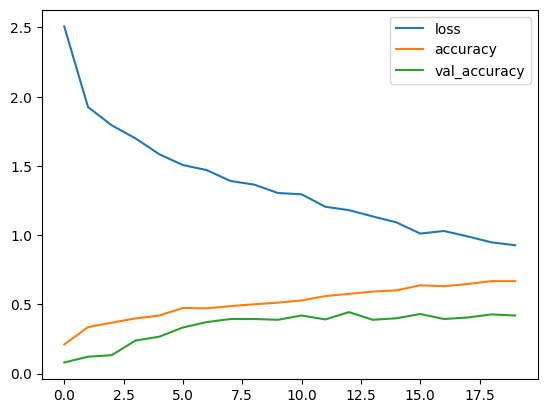

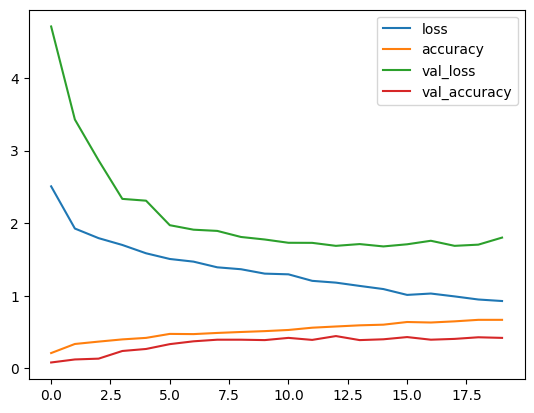

In [ ]:
logs = pd.DataFrame(cnnhistory.history)
logs[['loss', 'accuracy', 'val_accuracy']].plot();
logs.plot();

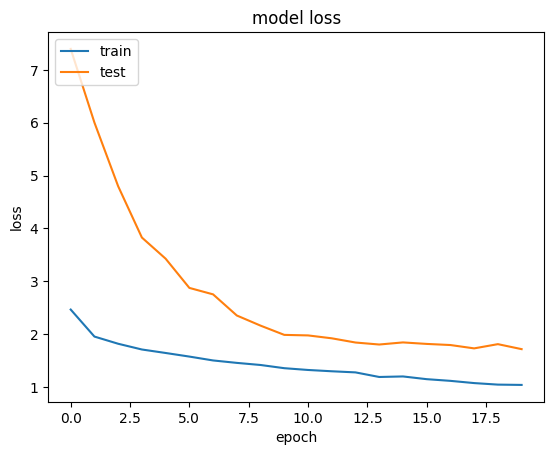

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(1, 216, 1))

x_train_norm = preprocess_input(np.array(x_traincnn))
x_test_norm = preprocess_input(np.array(x_testcnn))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)


ValueError: ignored

## Saving the model

In [ ]:
#model_name = 'Emotion_Voice_Detection_Model_2.h5'
#if e % 10 == 0:
#    model.save(f'/content/gdrive/My Drive/{model_name}.h5'.format(e))

#save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
#if not os.path.isdir(save_dir):
#    os.makedirs(save_dir)
#model_path = os.path.join(save_dir, model_name)
model.save('/content/drive/My Drive/emotional_speech_recognition.h5')
#print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/emotional_speech_recognition.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 39.66%


## Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

15/15 [==============================] - 1s 64ms/step


In [ ]:
preds

array([[1.6104063e-01, 5.0906767e-03, 1.5876752e-01, ..., 2.6905440e-02,
        1.8726679e-03, 1.1045947e-02],
       [6.0461005e-03, 8.4279180e-01, 1.7367683e-02, ..., 2.6280800e-04,
        1.0527451e-02, 2.9853713e-03],
       [1.7324458e-03, 1.2342522e-02, 2.0978164e-02, ..., 3.5150785e-02,
        1.0002204e-01, 1.0301593e-03],
       ...,
       [5.0254694e-05, 7.1091837e-01, 3.3896532e-02, ..., 2.2149443e-04,
        2.1807047e-02, 7.1170687e-04],
       [3.1685887e-04, 7.3436803e-01, 1.2084725e-02, ..., 3.2315904e-04,
        9.0358444e-03, 4.6253877e-04],
       [4.3013082e-03, 1.7080980e-04, 9.1245334e-04, ..., 6.6161538e-03,
        6.1543810e-01, 8.4374592e-02]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([ 4,  1,  8,  3,  3,  3, 11,  3, 10, 11,  3,  7,  7,  5,  6,  7,  3,
        4,  3, 13,  8,  8,  6,  7,  9, 13, 11, 13,  8,  7,  3,  6,  4,  7,
       10,  8,  4, 12, 10, 10, 11,  8, 13,  6,  3,  2,  1,  6,  6,  2,  5,
        8,  3, 11,  0,  2,  5, 10,  1,  6,  4,  2,  9,  6,  8,  6,  0,  8,
        5,  7, 10,  3,  2,  3, 12,  8,  8,  1,  1,  3,  8,  7,  7,  6,  8,
        2,  7, 11,  6,  8,  4,  0,  0,  1,  7, 11,  7,  8,  8,  1,  2,  6,
        1,  0,  2,  2,  1,  8, 10,  7,  9, 10,  1,  0,  1,  4,  1,  8,  8,
        2, 10,  8,  8,  1,  4, 12,  3,  1,  0,  6,  8,  8,  7,  5,  8,  6,
        8,  2,  0,  8,  4,  8,  7,  6,  8,  8,  3,  4,  7, 11,  7,  0,  7,
       13, 13, 12,  8,  7,  6,  2,  6, 13,  6,  9,  3,  8,  8,  3,  8,  7,
        0,  7,  1, 10,  4,  2,  0,  7,  3,  0,  2,  8,  8,  7,  7, 13,  0,
        8,  1,  2,  1,  7,  5,  6,  0, 12,  1,  5,  1, 10,  5,  7, 11,  3,
        7, 13,  8,  2,  1,  3, 12,  2,  7, 10, 13, 13, 10, 13,  9,  8,  0,
        6,  5,  0,  4, 13

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_happy
1,female_calm
2,male_calm
3,female_fearful
4,female_fearful
5,female_fearful
6,male_happy
7,female_fearful
8,male_fearful
9,male_happy


In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_happy
1,female_calm
2,female_disgusted
3,female_fearful
4,female_fearful
5,female_angry
6,male_happy
7,female_fearful
8,male_fearful
9,male_happy


In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_angry
171,male_angry,male_angry
172,female_calm,female_calm
173,male_fearful,male_fearful
174,female_angry,female_happy
175,male_disgusted,female_disgusted
176,female_fearful,female_angry
177,male_surprised,male_angry
178,female_fearful,female_fearful
179,male_angry,female_angry


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,35
female_calm,28
female_disgusted,22
female_fearful,41
female_happy,29
female_neutral,11
female_sad,38
female_surprised,15
male_angry,41


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,17
female_calm,31
female_disgusted,17
female_fearful,29
female_happy,31
female_neutral,43
female_sad,36
female_surprised,10
male_angry,30


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [ ]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/filename_6.wav')

Populating the interactive namespace from numpy and matplotlib


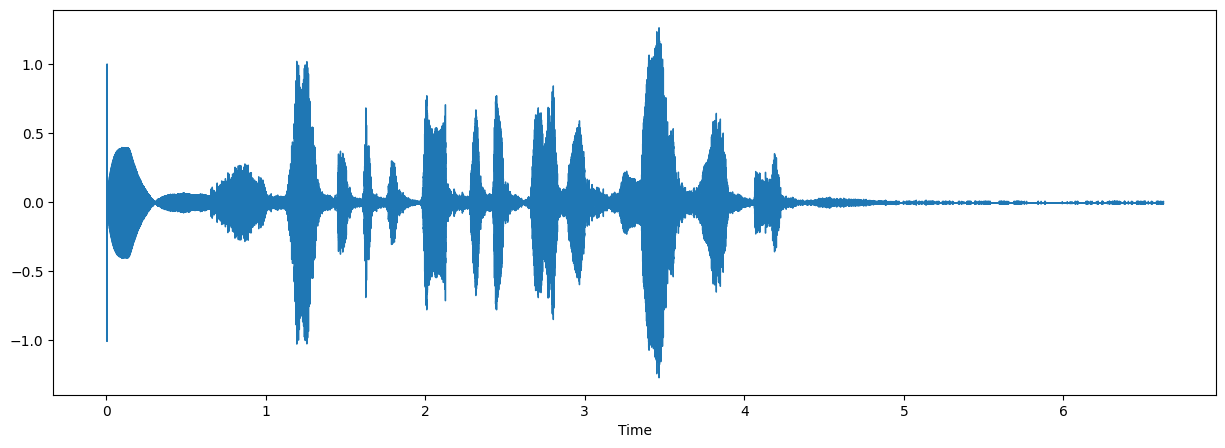

In [ ]:
%pylab inline
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('/content/drive/MyDrive/filename_6.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)

In [ ]:
livedf2 = livedf2.stack().to_frame().T

In [ ]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-5.891129,-9.720947,-21.747498,-27.435905,-23.089588,-22.189342,-30.842878,-27.018961,-23.776558,-19.802341,...,-18.27282,-17.900135,-19.745028,-19.986912,-19.64537,-21.656027,-20.724041,-20.080843,-18.30991,-14.557458


In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
livepreds = loaded_model.predict(twodim,
                         batch_size=32,
                         verbose=1)

1/1 [==============================] - 0s 27ms/step


In [ ]:
livepreds

array([[3.1425860e-30, 4.0889248e-32, 7.6456428e-18, 3.9242453e-26,
        1.2308700e-23, 8.9498168e-26, 5.7360012e-20, 2.5410548e-29,
        7.5763452e-13, 1.7299830e-21, 2.2835411e-11, 9.9931717e-01,
        6.8288454e-04, 9.7479484e-16, 1.0683336e-09, 4.8716213e-12]],
      dtype=float32)

In [ ]:
livepreds1=livepreds.argmax(axis=1)

In [ ]:
liveabc = livepreds1.astype(int).flatten()

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions = str(livepredictions)

if livepredictions == 'male_calm' or 'female_calm':
  print('calm')
elif livepredictions == 'male_angry' or 'female_angry':
  print('angry')
elif livepredictions == 'male_happy' or 'female_happy':
  print('happy')
elif livepredictions == 'male_surprised' or 'female_surprised':
  print('surpprised')
elif livepredictions == 'male_sad' or 'female_sad':
  print('sad')
elif livepredictions == 'male_fearful' or 'female-fearful':
  print('fearful')
elif livepredictions == 'male_disgusted' or 'female_disgusted':
  print('disgusted')

array(['male_fearful'], dtype=object)